In [1]:
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt
import pandas as pd

plt.rcParams['figure.figsize'] = (15,12)
plt.rcParams['font.size'] = 14
plt.rcParams['image.cmap'] = 'plasma'
plt.rcParams['axes.linewidth'] = 2

In [2]:
class SSA(object):
    
    __supported_types = (pd.Series, np.ndarray, list)
    
    def __init__(self, tseries, L):
        
        # разлагает ряд tseries с помощью сингулярного спектрального анализа. L - длина окна
        
        if not isinstance(tseries, self.__supported_types):
            raise TypeError("Преобразуйте временной ряд в Pandas Series, NumPy array или list.")
                
        self.N = len(tseries)
        if not 2 <= L <= self.N/2:
            raise ValueError("Длина окна должна быть в пределах [2, N/2].")
        
        self.L = L
        self.orig_TS = pd.Series(tseries)
        self.K = self.N - self.L + 1
        
        # преобразование ряда в матрицу
        self.X = np.array([self.orig_TS.values[i:L+i] for i in range(0, self.K)]).T
        
        # сингулярное разложение матрицы
        self.U, self.Sigma, VT = np.linalg.svd(self.X)
        self.d = np.linalg.matrix_rank(self.X)
        
        self.TS_comps = np.zeros((self.N, self.d))
        
        # построение элементарных матриц X[i]
        self.X_elem = np.array([ self.Sigma[i]*np.outer(self.U[:,i], VT[i,:]) for i in range(self.d) ])

        # чтобы каждая элементарная матрица была матрицей Ханкеля (с равными элементами в каждой антидиагонали),
        # проведем усреднение элементов в антидиагоналях
        for i in range(self.d):
            X_rev = self.X_elem[i, ::-1]
            self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]
            self.V = VT.T
        
        # считаем w-корреляционную матрицу
        self.calc_wcorr()
            
    def components_to_df(self, n=0):
        
        # преобразуем все компоненты в один DataFrame
        
        if n > 0:
            n = min(n, self.d)
        else:
            n = self.d
        
        # создаем список столбцов с именами F0, F1, F2, ...
        cols = ["F{}".format(i) for i in range(n)]
        return pd.DataFrame(self.TS_comps[:, :n], columns=cols, index=self.orig_TS.index)
            
    
    def reconstruct(self, indices):
        
        # восстанавливаем временной ряд из элементарных компонентов с номерами indices
        
        if isinstance(indices, int): indices = [indices]
        
        ts_vals = self.TS_comps[:,indices].sum(axis=1)
        return pd.Series(ts_vals, index=self.orig_TS.index)
    
    def calc_wcorr(self):
        
        # считаем w-корреляционную матрицу
                     
        # считаем веса
        w = np.array(list(np.arange(self.L)+1) + [self.L]*(self.K-self.L-1) + list(np.arange(self.L)+1)[::-1])
        
        def w_inner(F_i, F_j):
            return w.dot(F_i*F_j)
        
        # считаем взвешенные нормы векторов ||F_i||_w
        F_wnorms = np.array([w_inner(self.TS_comps[:,i], self.TS_comps[:,i]) for i in range(self.d)])
        F_wnorms = F_wnorms**-0.5
        
        # считаем Wcorr.
        self.Wcorr = np.identity(self.d)
        for i in range(self.d):
            for j in range(i+1,self.d):
                self.Wcorr[i,j] = abs(w_inner(self.TS_comps[:,i], self.TS_comps[:,j]) * F_wnorms[i] * F_wnorms[j])
                self.Wcorr[j,i] = self.Wcorr[i,j]
    
    def plot_wcorr(self, min=None, max=None):
        
        # строим w-корреляционную матрицу
        
        if min is None:
            min = 0
        if max is None:
            max = self.d
        
        if self.Wcorr is None:
            self.calc_wcorr()
        
        ax = plt.imshow(self.Wcorr)
        plt.xlabel(r"$\tilde{F}_i$")
        plt.ylabel(r"$\tilde{F}_j$")
        plt.colorbar(ax.colorbar, fraction=0.045)
        ax.colorbar.set_label("$W_{i,j}$")
        plt.clim(0,1)
        
        if max == self.d:
            max_rnge = self.d-1
        else:
            max_rnge = max
        
        plt.xlim(min-0.5, max_rnge+0.5)
        plt.ylim(max_rnge+0.5, min-0.5)
   

In [3]:
df = pd.read_csv("A_DeviceMotion_data\A_DeviceMotion_data\dws_1\sub_10.csv")
df.head()

,Unnamed: 0,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z
0,0,-1.529818,-0.176289,0.808758,-0.983669,0.175377,-0.040331,0.468650,1.218361,-0.611768,-0.081867,0.000312,-0.055387
1,1,-1.517146,-0.169138,0.815176,-0.984307,0.168333,-0.052859,0.212753,0.250286,-0.189299,-0.095008,-0.004942,0.016482
2,2,-1.513839,-0.166153,0.819115,-0.984624,0.165389,-0.056142,0.223693,0.163597,-0.098313,-0.050472,-0.080947,-0.085551
3,3,-1.519404,-0.166329,0.817491,-0.984892,0.165563,-0.050661,-0.207365,-0.424528,0.031889,-0.059115,-0.016667,-0.062758
4,4,-1.533914,-0.166594,0.812348,-0.985479,0.165825,-0.036363,-0.308759,-0.884469,0.055271,-0.051295,0.019295,-0.060118


In [4]:
cols = ["userAcceleration.x", "userAcceleration.y", "userAcceleration.z"]
accel_1 = (df[cols]**2).sum(axis=1)**0.5
accel_1.index /= 50

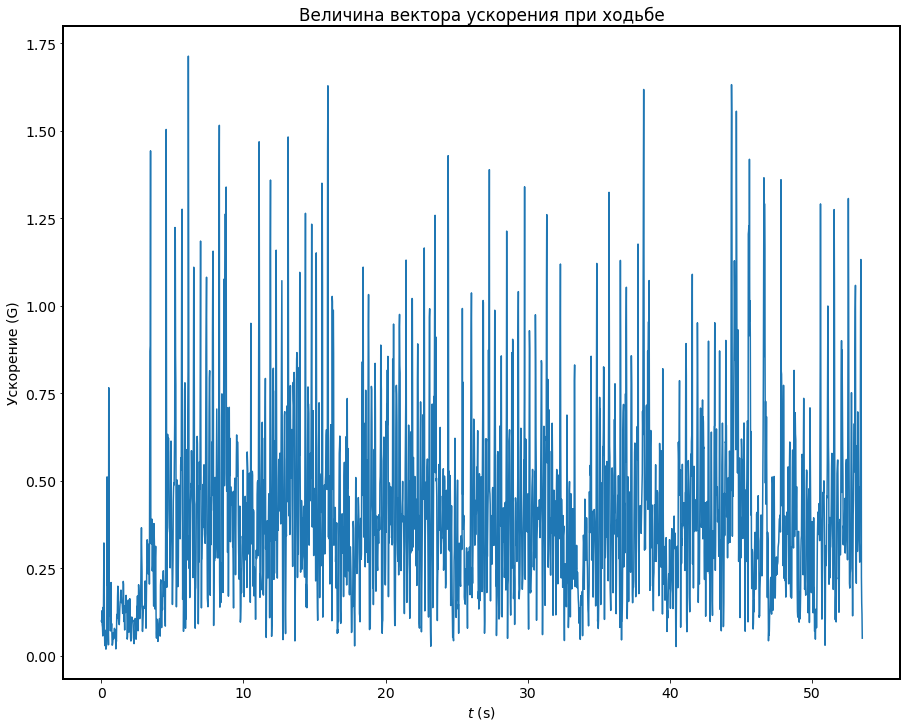

In [5]:
accel_1.plot()
plt.xlabel(r"$t$ (s)")
plt.ylabel("Ускорение (G)")
plt.title("Величина вектора ускорения при ходьбе");

In [6]:
start = 20 # seconds, not samples
end = 35 # seconds
window = 350 # samples
ssa_350 = SSA(accel_1, window)

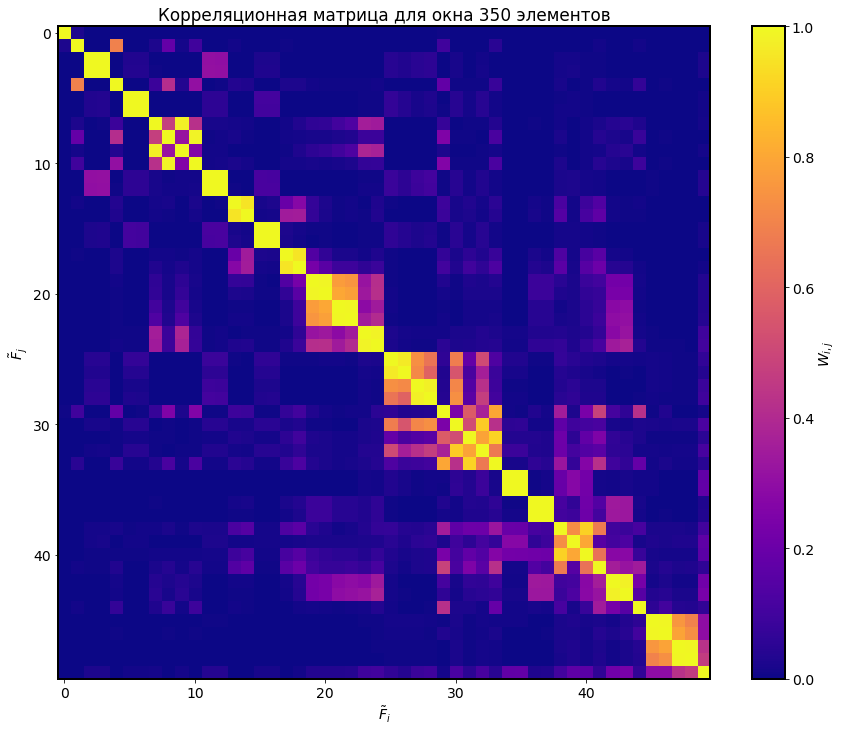

In [7]:
ssa_350.plot_wcorr(max=49)
plt.title("Корреляционная матрица для окна 350 элементов");

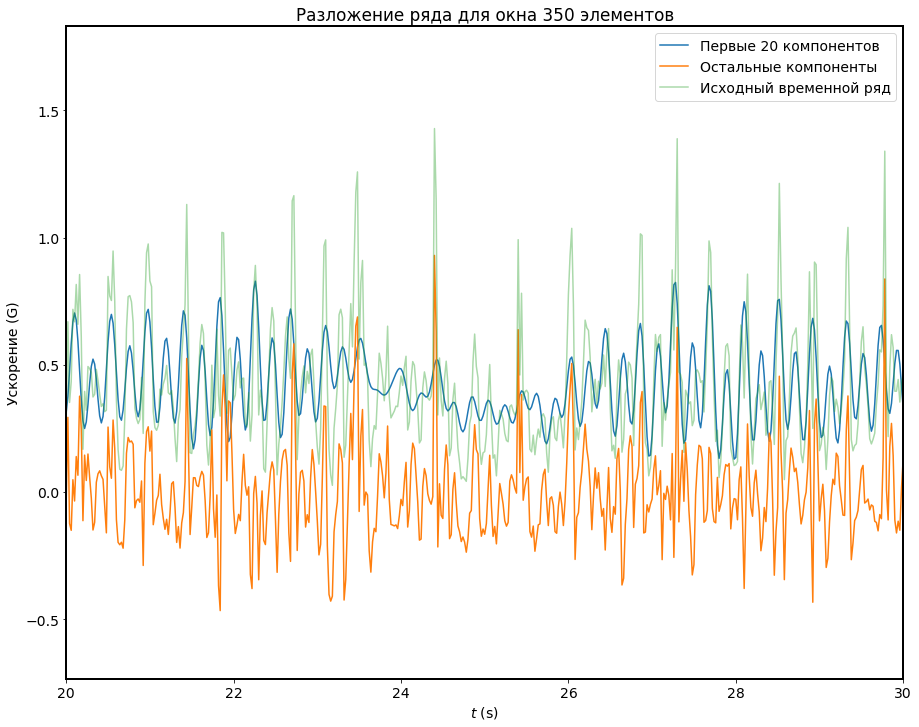

In [16]:
ssa_350.reconstruct(slice(0,23)).plot()
ssa_350.reconstruct(slice(23,350)).plot()
ssa_350.orig_TS.plot(alpha=0.4)
plt.xlabel(r"$t$ (s)")
plt.ylabel("Ускорение (G)")
plt.xlim(20,30)
plt.legend(["Первые 20 компонентов", "Остальные компоненты", "Исходный временной ряд"])
plt.title("Разложение ряда для окна 350 элементов");

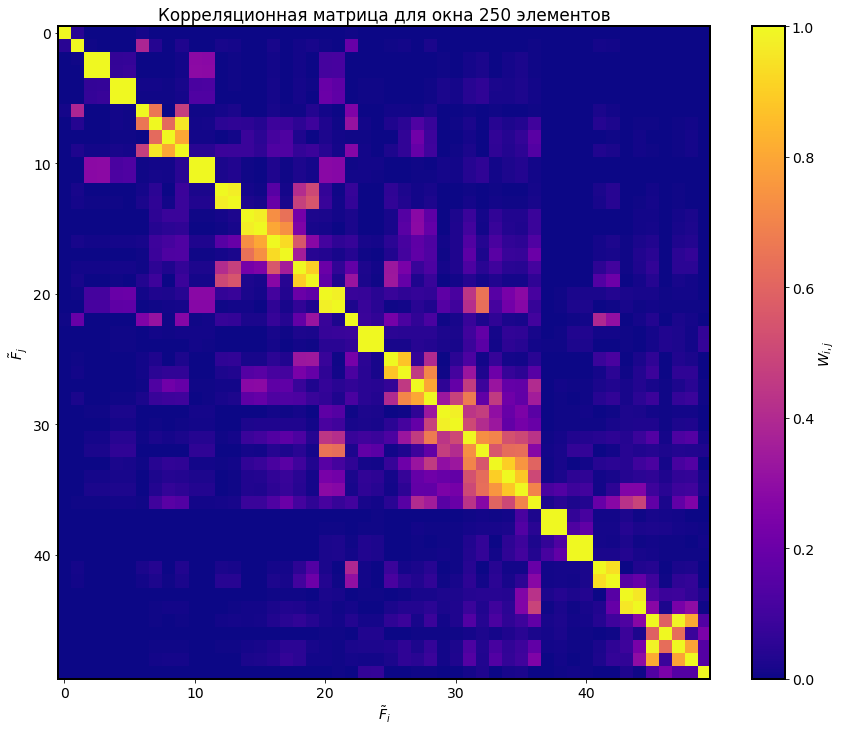

In [9]:
window = 250 
ssa_250 = SSA(accel_1, window)
ssa_250.plot_wcorr(max=49)
plt.title("Корреляционная матрица для окна 250 элементов");

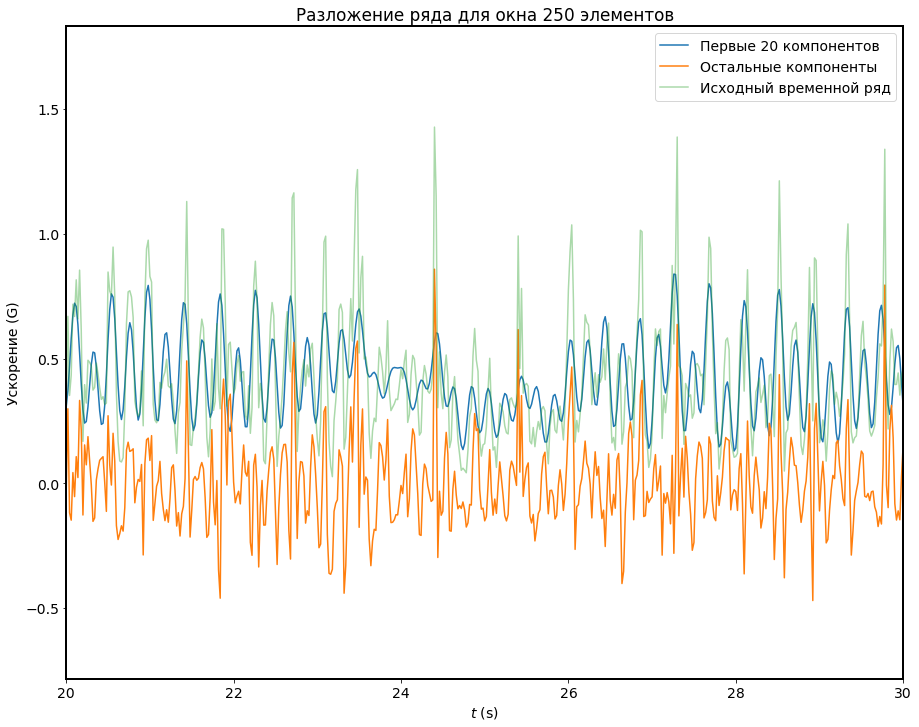

In [17]:
ssa_250.reconstruct(slice(0,23)).plot()
ssa_250.reconstruct(slice(23,250)).plot()
ssa_250.orig_TS.plot(alpha=0.4)
plt.xlabel(r"$t$ (s)")
plt.ylabel("Ускорение (G)")
plt.xlim(20,30)
plt.legend(["Первые 20 компонентов", "Остальные компоненты", "Исходный временной ряд"])
plt.title("Разложение ряда для окна 250 элементов");

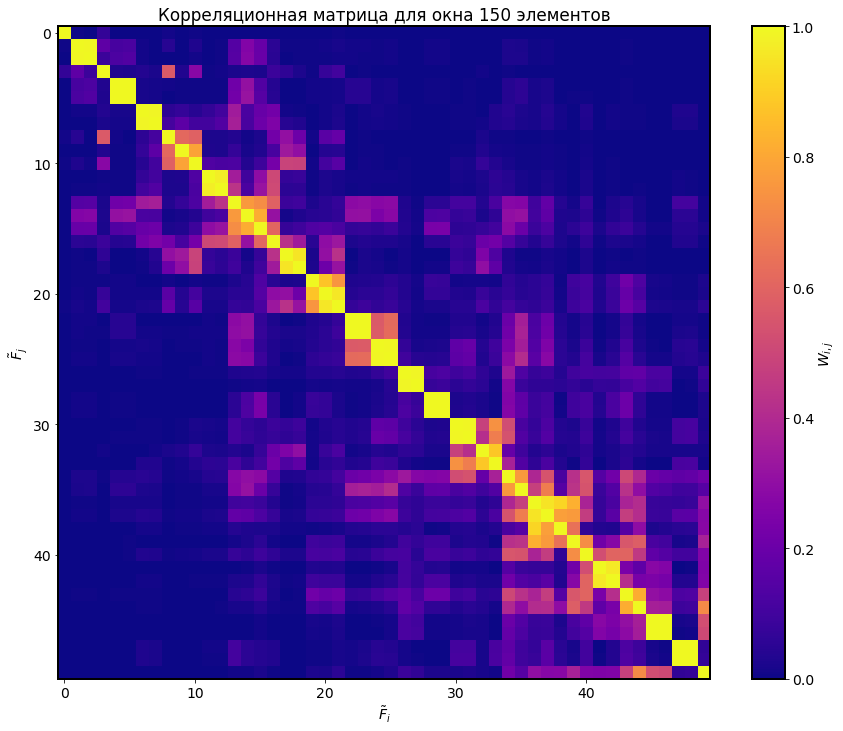

In [10]:
window = 150 
ssa_150 = SSA(accel_1, window)
ssa_150.plot_wcorr(max=49)
plt.title("Корреляционная матрица для окна 150 элементов");

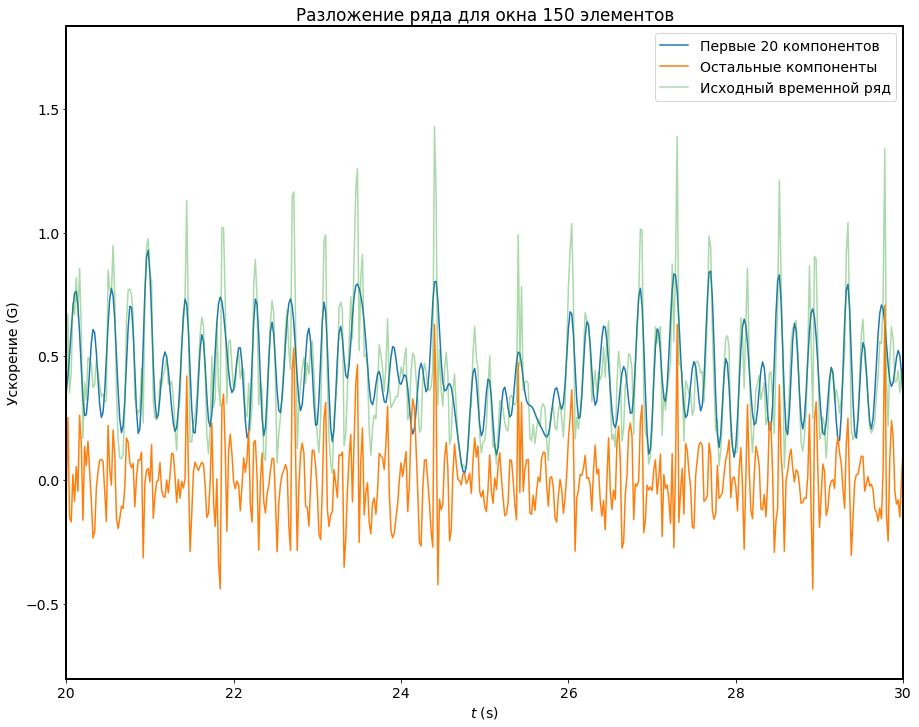

In [18]:
ssa_150.reconstruct(slice(0,23)).plot()
ssa_150.reconstruct(slice(23,150)).plot()
ssa_150.orig_TS.plot(alpha=0.4)
plt.xlabel(r"$t$ (s)")
plt.ylabel("Ускорение (G)")
plt.xlim(20,30)
plt.legend(["Первые 20 компонентов", "Остальные компоненты", "Исходный временной ряд"])
plt.title("Разложение ряда для окна 150 элементов");

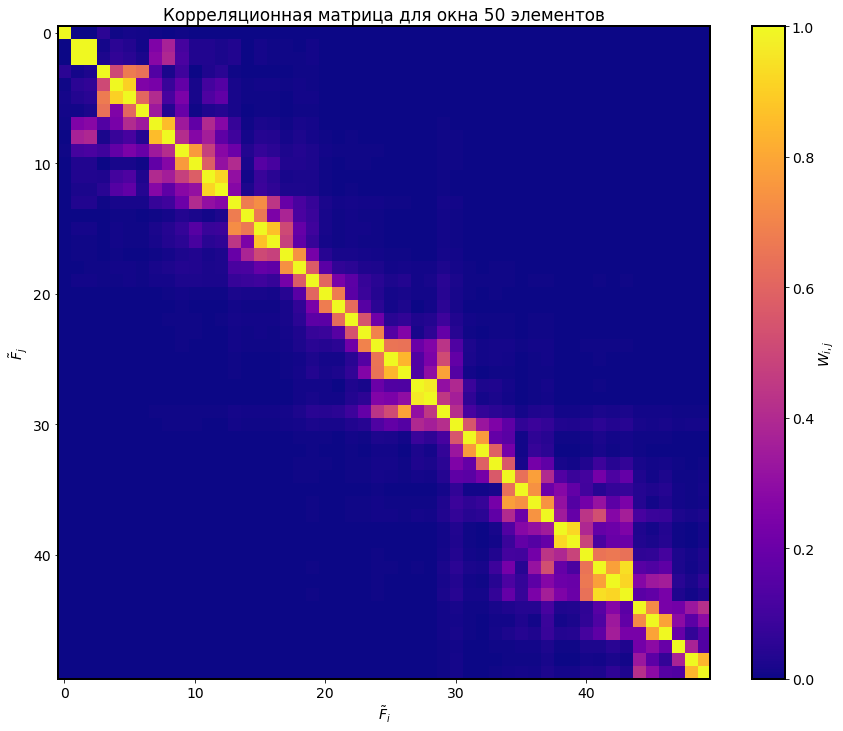

In [19]:
window = 50 
ssa_50 = SSA(accel_1, window)
ssa_50.plot_wcorr()
plt.title("Корреляционная матрица для окна 50 элементов");

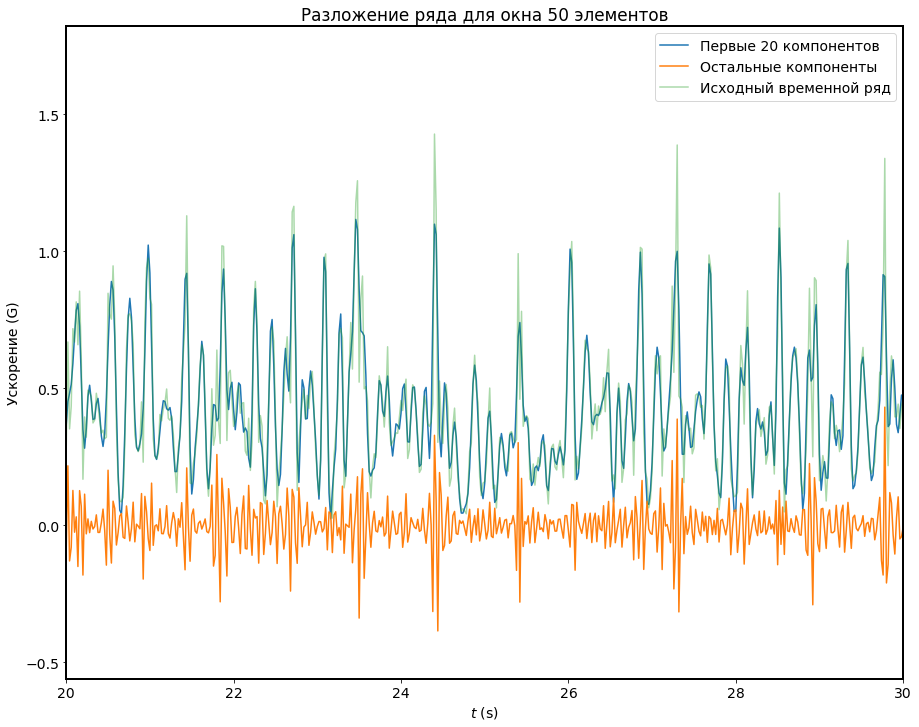

In [20]:
ssa_50.reconstruct(slice(0,23)).plot()
ssa_50.reconstruct(slice(23,50)).plot()
ssa_50.orig_TS.plot(alpha=0.4)
plt.xlabel(r"$t$ (s)")
plt.ylabel("Ускорение (G)")
plt.xlim(20,30)
plt.legend(["Первые 20 компонентов", "Остальные компоненты", "Исходный временной ряд"])
plt.title("Разложение ряда для окна 50 элементов");

Если исходный сигнал состоит из небольшого количества полезных колебаний и стационарного шума, то увеличение окна улучшает результат, т.к. позволяет более тщательно этот шум отфильтровать.

В случае же, когда исходный гармонический ряд имеет большое количество информативных гармоник высших порядков со значимыми коэффициентами (как в нашем случае), лучшие результаты получаются при уменьшении окна, т.к. 20 отобранных элементов из 50 лучше описывают исходный ряд, чем 20 элементов из 350.